<a href="https://colab.research.google.com/github/SofianeChehboune/Application-Streamlit-PySpark-Quiz/blob/main/Copie_de_Backpack_Prediction_Challenge_LGBM_XGBRegress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e2_path = kagglehub.competition_download('playground-series-s5e2')

print('Data source import complete.')


Data source import complete.


In [ ]:
!touch hello-colab-form-kaggle

In [ ]:
!ls

hello-colab-form-kaggle


In [ ]:

import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [ ]:
# Separate features and target
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")

In [ ]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [ ]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,300000.0,149999.500000,86602.684716,0.0,74999.750000,149999.500000,224999.250000,299999.0
Compartments,300000.0,5.443590,2.890766,1.0,3.000000,5.000000,8.000000,10.0
Weight Capacity (kg),299862.0,18.029994,6.966914,5.0,12.097867,18.068614,24.002375,30.0
Price,300000.0,81.411107,39.039340,15.0,47.384620,80.956120,115.018160,150.0


In [ ]:
train.isnull().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Image

In [ ]:
train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

<Axes: xlabel='id', ylabel='Price'>

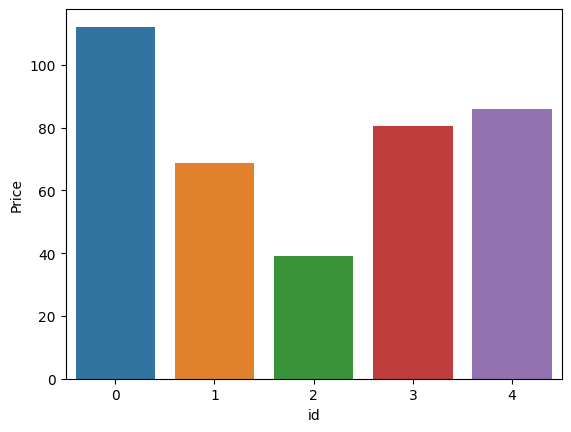

In [ ]:
sns.barplot(data = train.head(), x = 'id' , y = 'Price')

In [ ]:


# Set renderer for Kaggle
pio.renderers.default = "iframe"  # Essaie aussi "svg" ou "notebook"

# Load data
data = train

# Encode categorical columns
for col in ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]:
    data[col] = data[col].astype("category").cat.codes

# Creating the Parallel Coordinates graph
fig = px.parallel_coordinates(
    data,
    dimensions=data.columns,
    color="Price",
    color_continuous_scale=px.colors.sequential.Viridis
)

# Displaying the graph (Different solutions)
try:
    fig.show()
except:
    fig.write_image("plot.png")
    display(Image("plot.png"))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# Séparer les features et la cible
X = train.drop(columns=["Price", "id"])  # Supprime la cible et l'ID
y = train["Price"]
X_test = test.drop(columns=["id"])  # Supprime l'ID dans test

In [ ]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

In [ ]:
# Preprocessing pipelines with imputation and Replace NaNs with the median
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace NaNs with the median
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Remplace les NaN par la valeur la plus fréquente
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [ ]:
# Test XGBoost and LightGBM
models = {
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
}

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    print(f"\n🔹 Entraînement du modèle {name}...")



🔹 Entraînement du modèle XGBoost...

🔹 Entraînement du modèle LightGBM...


In [ ]:
# Test XGBoost and LightGBM
models = {
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
}

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    print(f"\n🔹 Entraînement du modèle {name}...")

    # Pipeline with the model
    full_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

   # Train the model
    full_pipeline.fit(X_train, y_train)

   # Evaluate the model
    y_pred = full_pipeline.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"✅ {name} - MAE sur validation : {mae:.2f}")

    # Prediction on test.csv
    test_predictions = full_pipeline.predict(X_test)


# Generate Submission
    submission = pd.DataFrame({"id": test["id"], "price": test_predictions})
    submission.to_csv(f"submission_{name}.csv", index=False)



🔹 Entraînement du modèle XGBoost...
✅ XGBoost - MAE sur validation : 33.67

🔹 Entraînement du modèle LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 2
[LightGBM] [Info] Start training from score 81.448481
✅ LightGBM - MAE sur validation : 33.67


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!git config --global user.name "Sofiane Chehboune"
!git config --global user.email "chehbounesofiane@gmail.com"

In [ ]:
!git clone https://github.com/VOTRE-UTILISATEUR/NOM-DU-REPO.git

Cloning into 'NOM-DU-REPO'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
%cd NOM-DU-REPO
!git add .
!git commit -m "Ajout du projet depuis Google Colab"
!git push origin main

[Errno 2] No such file or directory: 'NOM-DU-REPO'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
https://colab.research.google.com/github/Sofiane-chehbounesofiane/BackpackPredictionChallenge/blob/main/Backpack_Prediction_Challenge.ipynb

SyntaxError: invalid syntax (<ipython-input-8-a2de4fdcc48c>, line 1)